# Analyzing NYC High School Data


# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

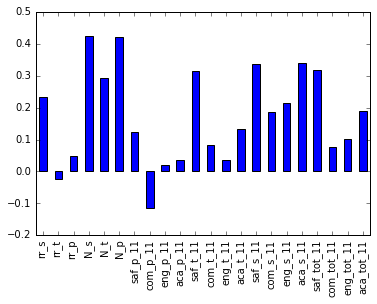

In [11]:
%matplotlib inline
correlations[survey_fields].plot.bar()

## This plot indicates
1.While the student response rate (rr_s) to the survey is positively correlated 
to the sat_score while interestingly the teacher response rate to the survey (rr_t) 
is negatively correlated to the sat_score. It makes sense that students with high 
sat score are very proactive in taking the survey.
2. The Number of student, teacher and parent respondents (N_s, N_t, N_p) are very highly-
positively correlated to the sat_score.
3. The Safety and Respect score based on both tacher and parent responses (saf_p_11, saf_t_11) are positively 
correlated with sat_score which makes sense as productive education cannot be taught is unsafe 
environment.
4. Student with high Academic Expectations (aca_s_11) have high sat_scores which totally makes sense. But interestingly
Teachers Academic Expectations (aca_t_11) though positively correlated is not as high as students expectations.


In [ ]:
combined.plot.scatter("saf_s_11","sat_score")

## Plot indicates:
The students who have responded safety score of less than 7 have less than average
sat scores. Some students who have high safet score do have a postively high correlation
with high sat scores. But there are also few students who have high safety score but
are have scored less than average sat scores.


## Plotting Safety Score for each district ##

In [14]:
import numpy as np
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace = True)


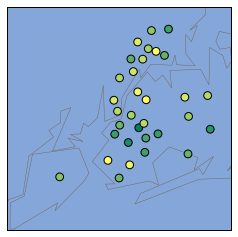

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=60, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

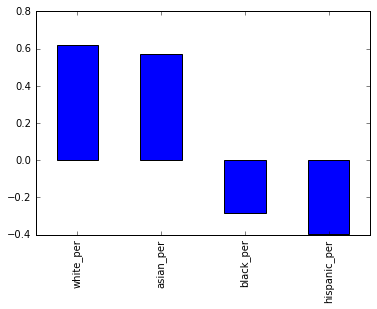

In [16]:
races = ["white_per","asian_per", "black_per", "hispanic_per"]
correlations[races].plot.bar()
plt.show()

## The plot indicates:
The schools with high volume of White and Hispanic students have very postivite correlation 
to the sat_score while the schools with more Black and Hispanic puppulation have very 
negative correlation of sat scores. 
There might be many factors affecting the schools with 
high black and hispanic students, like:
-safety, 
-funding to have better teachers, 
-location of school, 
-level of parent education and encouragement, 
-disrruptive external factors like influence of drugs

## Schools with hispanic_per greater than 95 ##

In [ ]:
print(combined[combined["hispanic_per"]>95]["SCHOOL NAME"], combined[combined["hispanic_per"]>95]["sat_score"])

## Analysis from these schools indicate there is high percent of students who are part of English Language Learners (ELL) club and 
among them top % of students are hispanics. Among top 10 home languages in all boroughs Spanish is the topper with 61% which 
makes sense why Hispanics (among all 4 races) have least SAT scores.

In [ ]:
print(combined[((combined["hispanic_per"]<10) & (combined["sat_score"]>1800))]["SCHOOL NAME"])

## All the above schools need "SHSAT" (Specialized High Schools Admission Test) to get into 
the school. This tests students English and Mathematics, so obviously students who take 
this test should have good English. So the hispanic students who are taking this test 
should have good english unlike the hispanic students in above analysis where most of 
them take ELL classes to learn english.

In [ ]:
combined.plot.scatter("hispanic_per", "sat_score")

## Plotting and Analyzing Gender differences in SAT scores ##

In [ ]:
genders = ["male_per", "female_per"]
correlations[genders].plot.bar()

## The above bar indicates:
Higher female percentage in schools is positively correlated with the sat scores and
contrarily schools with very high male percentage have negative correlation witht the sat scores.


In [ ]:
combined.plot.scatter("female_per", "sat_score")

## From above plot: Schools with female percentage ranging between 40-50% 
have high concerntration of scores ranging from 1000 to 1200. There are 
few schools with female percentage between 40-80 having high score on sat 
but this scatter plot do no show any proper correlation between number of female
students in a school and thier sat scores.

In [19]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


## These schools look like they are specialized schools, selective preparatory schools,
schools specialized in Arts and Performance. One of the school is consistently been 
on top 100 US schools list. It makes sense that students in these schools will be 
highly competitive with very high sat scores.

In [21]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]


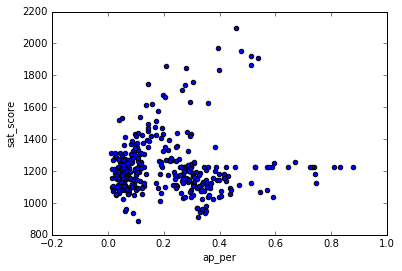

In [22]:
combined.plot.scatter("ap_per", "sat_score")

## There is some correlation between sat_scores and percentake of students who took AP in that school but the
correlation is not strong. No significant conclusion can be drawn.

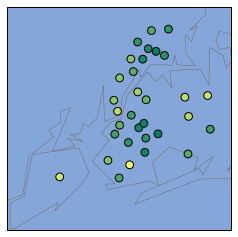

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=60, zorder=2, latlon=True, c=districts["sat_score"], cmap="summer")
plt.show()


## Assigning ranks to schools based on sat scores

In [40]:
combined['School_Rank'] = combined["sat_score"].rank(method = "dense")
print(combined["School_Rank"])

0       68.0
1      104.0
2       87.0
3      133.0
4      227.0
5      238.0
6      113.0
7      123.0
8       93.0
9       60.0
10     180.0
11     168.0
12      23.0
13      86.0
14     127.0
15      71.0
16     108.0
17     212.0
18     144.0
19     144.0
20     144.0
21     207.0
22     222.0
23     225.0
24     231.0
25     207.0
26     235.0
27     226.0
28     102.0
29     182.0
       ...  
333    177.0
334     53.0
335    144.0
336    141.0
337     89.0
338    144.0
339    161.0
340    173.0
341    139.0
342    220.0
343    152.0
344     71.0
345    217.0
346    229.0
347    196.0
348    124.0
349    209.0
350    174.0
351    175.0
352    181.0
353    206.0
354    201.0
355    149.0
356    242.0
357     51.0
358     91.0
359     17.0
360     27.0
361    186.0
362     25.0
Name: School_Rank, dtype: float64
